In [797]:
#import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#display options
from IPython.display import display
pd.options.display.float_format = '{:.2f}'.format

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale = 1.8)

import warnings
#warnings.SettingWithCopyWarning
pd.options.mode.chained_assignment = None

#read the collected data
df_init = pd.read_csv('final_movie_data.csv',index_col=0)

df = df_init.copy()
df.head(2)

,title,budget,revenue,genres,production_countries,production_companies,adult,popularity,original_language,release_date,runtime,vote_average,vote_count
0,Independence Day,75000000,817400891,"Action, Adventure, Science Fiction",United States of America,"Centropolis Entertainment, 20th Century Fox",False,17.07,en,1996-06-25,145.00,6.80,5595
1,The Matrix,63000000,463517383,"Action, Science Fiction","Australia, United States of America","Village Roadshow Pictures, Groucho II Film Par...",False,35.72,en,1999-03-30,136.00,8.10,14757


In [798]:
#####preprocessing#####

#fill missing values for run time with median
df.runtime.fillna(df_init.runtime.median(),inplace=True)

#fill mising values with 'missing'
df.genres.fillna('missing',inplace=True)
df.production_countries.fillna('missing',inplace=True)
df.production_companies.fillna('missing',inplace=True)

#rescale bugdet to list in million $
scale = 10**6
df['budget_M'] = df['budget'].div(scale)
df['revenue_M'] = df['revenue'].div(scale)

#total budget in million $ and %
df['return_M'] = df.revenue_M - df.budget_M
df['gain/loss_%'] = round((df.return_M/df.budget_M - 1) * 100, 2)

#add positive/negative return %
df['return_type'] = df['gain/loss_%'].map(lambda x: 'gain'
                                       if x > 0 else 'loss')

#add year column
df.release_date = df.release_date.astype('datetime64[ns]')
df['year'] = df.release_date.dt.year.fillna(0).astype('int64')

#add first genre column
df['first_genre'] = [x.split(', ')[0] if x is not np.nan 
                                           else np.nan for x in df.genres]
#add first company column
df['first_company'] = [x.split(', ')[0] if x is not np.nan 
                                             else np.nan for x in df.production_companies]
#add first country column
df['first_country'] = [x.split(', ')[0] if x is not np.nan 
                                             else np.nan for x in df.production_countries]

#select necessary columns
df = df[['title','year','first_genre','first_country','first_company',
         'budget_M','revenue_M','return_M','gain/loss_%','return_type','runtime']]   


df.head()

,title,year,first_genre,first_country,first_company,budget_M,revenue_M,return_M,gain/loss_%,return_type,runtime
0,Independence Day,1996,Action,United States of America,Centropolis Entertainment,75.00,817.40,742.40,889.87,gain,145.00
1,The Matrix,1999,Action,Australia,Village Roadshow Pictures,63.00,463.52,400.52,535.74,gain,136.00
2,The Matrix Reloaded,2003,Adventure,Australia,Heineken Branded Entertainment,150.00,738.60,588.60,292.40,gain,138.00
3,The Matrix Revolutions,2003,Adventure,United States of America,Silver Pictures,150.00,424.99,274.99,83.33,gain,129.00
4,Out of Africa,1985,History,United States of America,Universal Pictures,31.00,128.50,97.50,214.51,gain,161.00


In [799]:
df.describe()

,year,budget_M,revenue_M,return_M,gain/loss_%,runtime
count,5390.00,5390.00,5390.00,5390.00,5390.00,5390.00
mean,1957.98,26.34,72.50,46.16,1038138.75,108.59
std,292.13,62.94,155.62,138.33,57601744.31,37.54
min,0.00,0.00,-0.00,-3499.05,-300.00,1.00
25%,1995.00,2.00,1.89,-0.38,-117.98,94.00
50%,2006.00,10.50,16.16,3.66,-4.92,105.00
75%,2012.00,30.00,71.28,40.59,203.82,121.00
max,2020.00,3500.05,2787.97,2550.97,4166449800.00,2000.00


In [800]:
df.describe(include=['object'])

,title,first_genre,first_country,first_company,return_type
count,5390,5390,5390,5390,5390
unique,5312,20,82,2322,2
top,The Three Musketeers,Drama,United States of America,missing,loss
freq,3,1305,2975,450,2785


In [801]:
#analysis of categorical columns
#function to select top most frequent categories
def quick_cat(_series,top_number):
    #count values in a column and normalize to show percentage
    top = _series.value_counts(normalize=True)[:top_number]    
    
    #print(f"Number of unique values is {_series.nunique()}.")
    #print(f"The first {top_number} items are present in {round(top.sum()*100,1)} % of data.")   
    return top

#select top most frequent genres
select_genre = quick_cat(df.first_genre,top_number=6).index
df['select_genre'] = df['first_genre'].map(lambda x: x if x in select_genre else 'other')

#define hue_order to compare different plots
hueorder = list(select_genre)
hueorder.append('other')

#select top most frequent countries
select_country = list(quick_cat(df.first_country,top_number=6).index)
select_country.remove('missing')
df['select_country'] = df['first_country'].map(lambda x: x if x in select_country else 'other')

#select top most frequent companies
select_company = list(quick_cat(df.first_company,top_number=21).index)
select_company.remove('missing')
df['select_company'] = df['first_company'].map(lambda x: x if x in select_company else 'other')

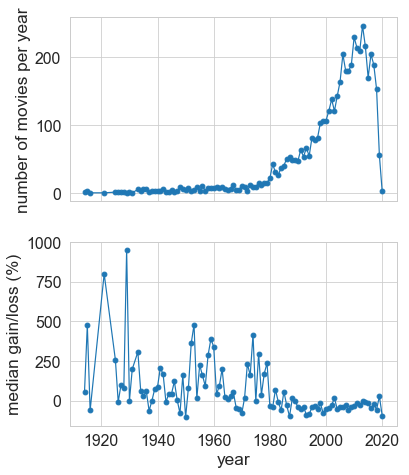

In [802]:
#What is distribution of movies by a year?
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,7),sharex=True)

#filter missing years and return greater than 1000%
filter_cond = (df.year > 0) & (df['gain/loss_%'] < 1000)

##subplot 1
#numbers of movies over time in the database
df[filter_cond].year.value_counts().sort_index()\
               .plot(kind='line',ax=ax1,marker='o')

#change axis labels
ax1.set_xlabel('year')
ax1.set_ylabel('number of movies per year')

##subplot 2
#Median return in % versus release year
df[filter_cond].groupby('year')['gain/loss_%'].median()\
               .plot(kind='line',ax=ax2,marker='o')

#change axis labels
ax2.set_xlabel('year')
ax2.set_ylabel('median gain/loss (%)')

#change axis limits
#ax2.set_ylim(0,150)
#ax2.set_xlim(1987,2018)
plt.tight_layout()

50.7% of movies have negative return.


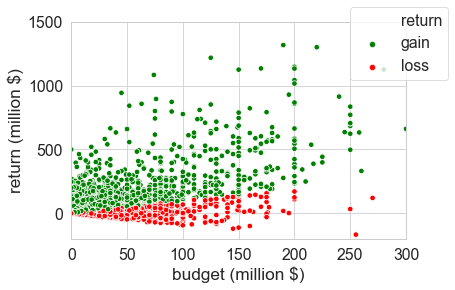

In [803]:
#How budget influence on total revenue in millions?
fig, ax1 = plt.subplots(1,1,figsize=(6,4))

#plot return vs budget in millions $
sns.scatterplot(x='budget_M', y='return_M', hue='return_type',
                data=df, s=30, ax=ax1,palette=['green','red'])

#change axis labels
ax1.set_xlabel('budget (million $)')
ax1.set_ylabel('return (million $)')

#legend parameters
ax1.legend(loc='right',bbox_to_anchor = [1.15, 0.9])\
   .texts[0].set_text("return")

#change axis limits
ax1.set_xlim(0,300)
ax1.set_ylim(-200,1500)

#What is the percentage of movies with negative return?
neg_return = round(df[df['gain/loss_%'] < 0].shape[0] 
                   / df.shape[0] * 100,1)
print(f'{neg_return}% of movies have negative return.')

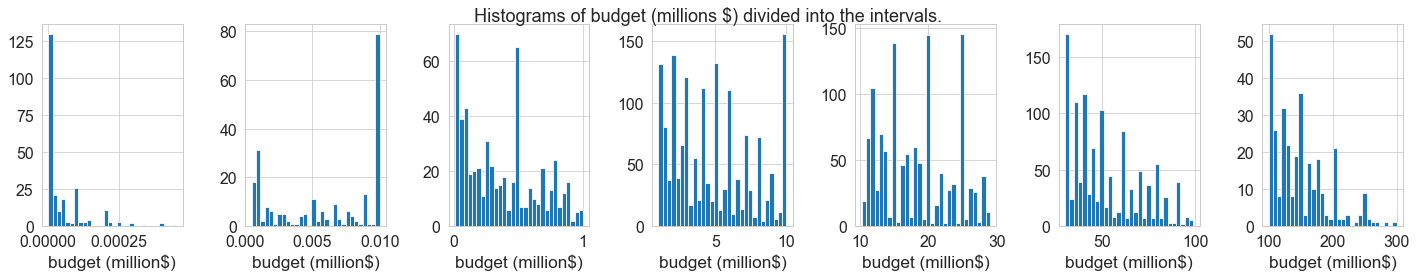

In [804]:
#What is distribution of movies by a budget?
#How to categorize the budget?
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1,7,figsize=(20,4))

df[df.budget_M < 0.0005].budget_M.hist(bins=30,ax=ax1) #under 0.5k
ax1.set_xlabel('budget (million$)')

df[(df.budget_M >= 0.0005) & (df.budget_M <= 0.01)].budget_M.hist(bins=30,ax=ax2) #between 0.5k and 10k
ax2.set_xlabel('budget (million$)')

df[(df.budget_M > 0.01) & (df.budget_M < 1)].budget_M.hist(bins=30,ax=ax3) #between 10k and 1M
ax3.set_xlabel('budget (million$)')

df[(df.budget_M >= 1) & (df.budget_M <= 10)].budget_M.hist(bins=30,ax=ax4) #between 1M and 10M
ax4.set_xlabel('budget (million$)')

df[(df.budget_M > 10) & (df.budget_M < 30)].budget_M.hist(bins=30,ax=ax5) #between 10M and 30M
ax5.set_xlabel('budget (million$)')

df[(df.budget_M >= 30) & (df.budget_M < 100)].budget_M.hist(bins=30,ax=ax6) #between 30M and 100M
ax6.set_xlabel('budget (million$)')

df[(df.budget_M >= 100) & (df.budget_M <= 300)].budget_M.hist(bins=30,ax=ax7) #over 100M
ax7.set_xlabel('budget (million$)')

#add common title
plt.suptitle('Histograms of budget (millions $) divided into the intervals.',fontsize=18)
plt.tight_layout()

In [805]:
#add a new column with budget categories
df['budget_category'] = pd.cut(df.budget_M,[0,0.0005,0.01,1,10,30,100,1000],
                               labels=['< 0.5k','[0.5k, 10k]',
                                       '(10k, 1M)',
                                       '[1M, 10M]',
                                       '(10M, 30M)',
                                       '[30M, 100M)',
                                       '>= 100M'
                                      ])

In [806]:
#filter the outliers in terms of return
filter_cond = ((df['gain/loss_%'] < 1000) & (df['budget_M'] < 0.0005)) \
                | ((df['gain/loss_%'] < 3000) & (df['budget_M'] >= 0.0005))

In [807]:
#other filters 
filter_other_company = (df.select_company != 'other') 

,title,first_genre,first_country,first_company,return_type
count,5247,5247,5247,5247,5247
unique,5177,20,82,2255,2
top,King Kong,Drama,United States of America,missing,loss
freq,3,1266,2891,431,2785


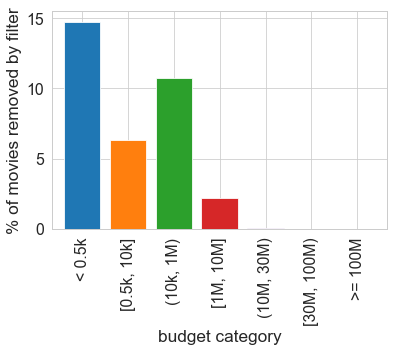

In [808]:
#What is the percentage of data filtered from data 
fig, ax1 = plt.subplots(1,1,figsize=(6,4))

filter_count = df[~filter_cond].groupby('budget_category')['budget_category'].count()
keep_count = df[filter_cond].groupby('budget_category')['budget_category'].count()

(filter_count/keep_count*100).plot(kind='bar',width=0.8)

ax1.set_xlabel('budget category')
ax1.set_ylabel('% of movies removed by filter')

df[filter_cond].describe(include=['object']).iloc[:,:5]

,Q1,Q2 (median),Q3
budget,,,
< 0.5k,-120.56,-100.00,0.00
"[0.5k, 10k]",-100.00,-39.02,248.98
"(10k, 1M)",-100.00,37.08,393.11
"[1M, 10M]",-146.73,-10.47,222.78
"(10M, 30M)",-139.07,-36.39,148.46
"[30M, 100M)",-107.78,-17.77,111.93
>= 100M,-13.48,76.47,219.55


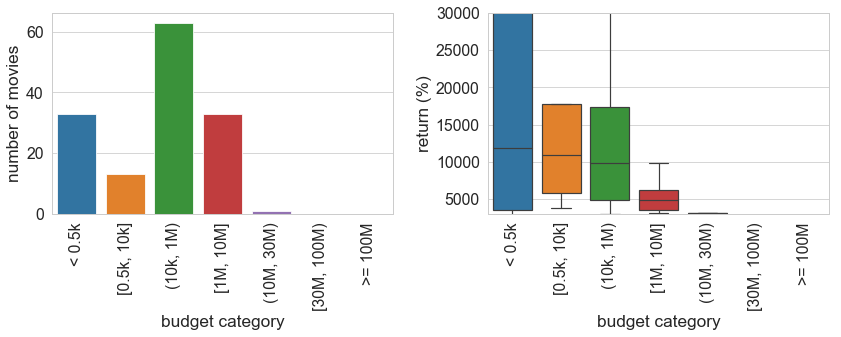

In [809]:
#analyze the filtered data
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

#plot the number of movies versus budget category
sns.countplot(x='budget_category', data=df[~filter_cond], ax=ax1)
#change axis labels
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
ax1.set_xlabel('budget category')
ax1.set_ylabel('number of movies')

#plot return in % versus budget category
sns.boxplot(x='budget_category',y='gain/loss_%',data=df[~filter_cond],showfliers=False,ax=ax2)
#change axis labels
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)
ax2.set_xlabel('budget category')
ax2.set_ylabel('return (%)')
ax2.set_ylim(3000,30000)

plt.tight_layout()

#summary
d = df[filter_cond].groupby('budget_category')['gain/loss_%']\
                   .agg([perc_25,np.median,perc_75])
d.index.names = ['budget']
d.rename(columns={'perc_25':'Q1','median':'Q2 (median)','perc_75':'Q3'},inplace=True)
display(d)

,Q1,Q2 (median),Q3
budget,,,
< 0.5k,-120.56,-100.00,0.00
"[0.5k, 10k]",-100.00,-39.02,248.98
"(10k, 1M)",-100.00,37.08,393.11
"[1M, 10M]",-146.73,-10.47,222.78
"(10M, 30M)",-139.07,-36.39,148.46
"[30M, 100M)",-107.78,-17.77,111.93
>= 100M,-13.48,76.47,219.55


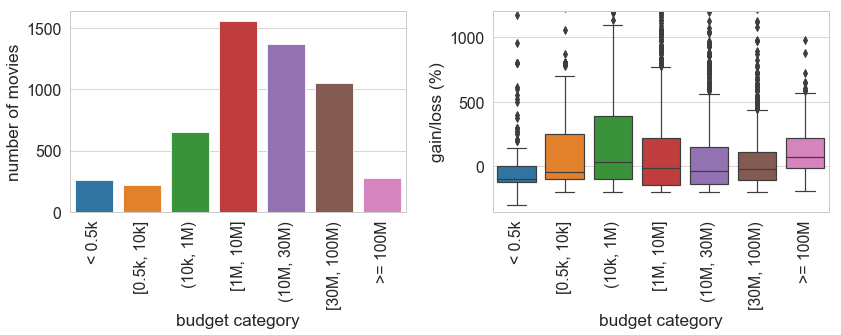

In [810]:
#return vs budget category: how much money to invest?
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

#plot the number of movies versus budget category
sns.countplot(x='budget_category', data=df, ax=ax1)#[filter_cond]
#change axis labels
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
ax1.set_xlabel('budget category')
ax1.set_ylabel('number of movies')

#plot return in % versus budget category
sns.boxplot(x='budget_category',y='gain/loss_%',data=df[filter_cond],showfliers=True,ax=ax2)
#change axis labels
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)
ax2.set_xlabel('budget category')
ax2.set_ylabel('gain/loss (%)')
ax2.set_ylim(-350,1200)

plt.tight_layout()

#add table with median and 25,75 percentiles
def perc_25(x):
    return np.percentile(x, q = [25])
def perc_75(x):
    return np.percentile(x, q = [75])

d = df[filter_cond].groupby('budget_category')['gain/loss_%']\
                   .agg([perc_25,np.median,perc_75])
d.index.names = ['budget']
d.rename(columns={'perc_25':'Q1','median':'Q2 (median)','perc_75':'Q3'},inplace=True)
display(d)

budget_category,< 0.5k,"[0.5k, 10k]","(10k, 1M)","[1M, 10M]","(10M, 30M)","[30M, 100M)",>= 100M
select_genre,,,,,,,
Action,19,42,47,230,204,247,103
Adventure,5,2,17,55,82,108,78
Comedy,34,33,111,338,312,208,5
Crime,3,2,28,86,78,57,1
Drama,29,53,188,427,377,178,14
Horror,15,7,43,115,84,36,2
other,119,67,152,278,236,216,75


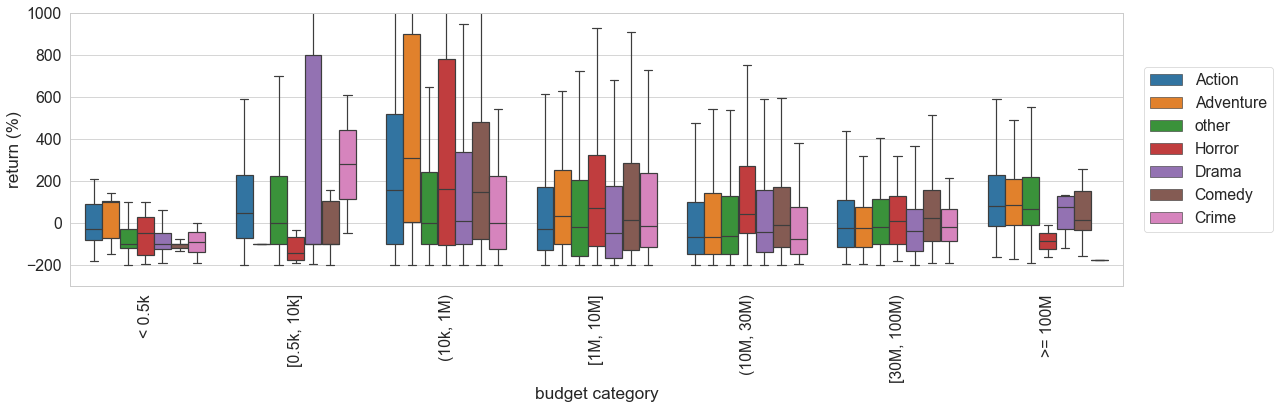

In [834]:
#How genre influence the return in different budget categories?
fig, ax = plt.subplots(1,1,figsize=(18,6))

#plot return in % versus budget category for most common genres
ax = sns.boxplot(x='budget_category',y='gain/loss_%',hue='select_genre',
            data=df[filter_cond],showfliers=False)

#change legend location
ax.legend(loc='right',bbox_to_anchor = [1.15, 0.5])
#change axis labels
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_xlabel('budget category')
ax.set_ylabel('return (%)')
ax.set_ylim(-300,1000)

plt.tight_layout()

#add table showing numbers of movies in a given budget category and genre
df[filter_cond].groupby(['select_genre','budget_category'])\
                        ['budget_category'].count().unstack().fillna(0).astype('int64')

budget,< 0.5k,"[0.5k, 10k]","(10k, 1M)","[1M, 10M]","(10M, 30M)","[30M, 100M)",>= 100M
,,,,,,,
Canada,3,3,8,52,64,45,10
France,1,0,6,56,61,42,3
India,13,5,115,202,33,5,1
United Kingdom,11,4,21,100,101,60,31
United States of America,51,53,212,756,896,734,188
other,145,141,224,363,218,164,45


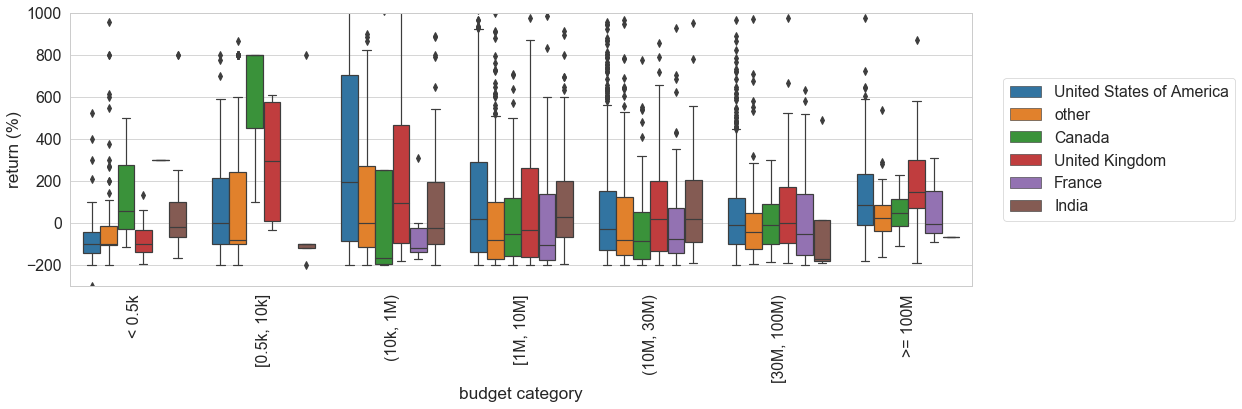

In [812]:
#How country influence the return in different budget categories?
fig, ax = plt.subplots(1,1,figsize=(18,6))

#plot return in % versus budget category for most common countries
ax = sns.boxplot(x='budget_category',y='gain/loss_%',hue='select_country',
            data=df[filter_cond],showfliers=True)
#change legend location
ax.legend(loc='right',bbox_to_anchor = [1.3, 0.5])
#change axis labels
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_xlabel('budget category')
ax.set_ylabel('return (%)')
ax.set_ylim(-300,1000)

plt.tight_layout()

#add table showing numbers of movies in a given budget category and country
df_count = df[filter_cond].groupby(['select_country','budget_category'])\
                                   ['budget_category'].count().unstack()\
                                                      .fillna(0).astype('int64')
#rename index names
df_count.index.names = ['']
df_count.columns.names = ['budget']

df_count

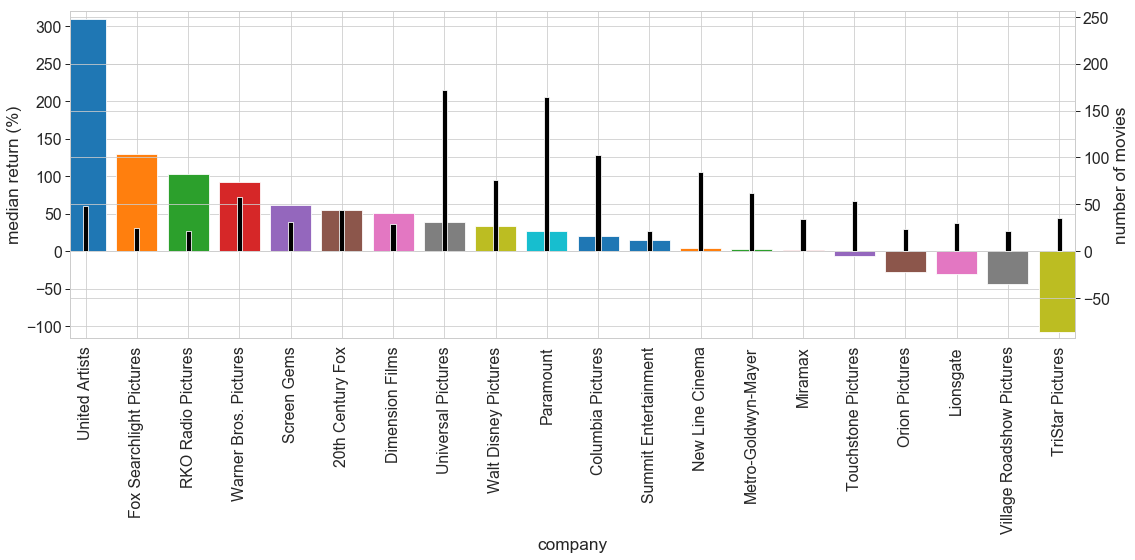

In [832]:
#How company influence the return in different budget categories?
fig, ax1 = plt.subplots(1,1,figsize=(18,6))


#plot return in % versus budget category for different companies
#select a group
group = df[filter_cond & filter_other_company]\
                       .groupby('select_company')['gain/loss_%']\
                       .agg(['median','count'])\
                       .sort_values(by='median',ascending=False).iloc[:20]
#plot
group['median'].plot(kind='bar',ax=ax1,width=0.8)#pos

#change axis labels
ax1.set_ylabel('median return (%)')
ax1.set_xlabel('company')
f=1.6
f1=f*3.6
ax1.set_ylim(-20*f1,200*f)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
group['count'].plot(kind='bar',ax=ax2,color='k',width=0.1)
ax2.set_ylabel('number of movies')
_ = ax2.set_ylim(-16*f1,160*f)

In [815]:
def plot_return_filter(filter_add,hue_by,hue_order,_xlim,_ylim,_title,):
    fig, ax = plt.subplots(1,1,figsize=(18,6))

    #plot return in % versus budget category for most common genres
    ax = sns.boxplot(x='budget_category',y='gain/loss_%',hue=hue_by,
                     hue_order = hue_order,
                     data=df[filter_cond & filter_add],showfliers=False)

    #change legend location
    ax.legend(loc='right',bbox_to_anchor = [1.15, 0.5])
    #change axis labels
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    ax.set_xlabel('budget category')
    ax.set_ylabel('return (%)')
    ax.set_xlim(_xlim)
    ax.set_title(_title)
    ax.set_ylim(_ylim)

    plt.tight_layout()

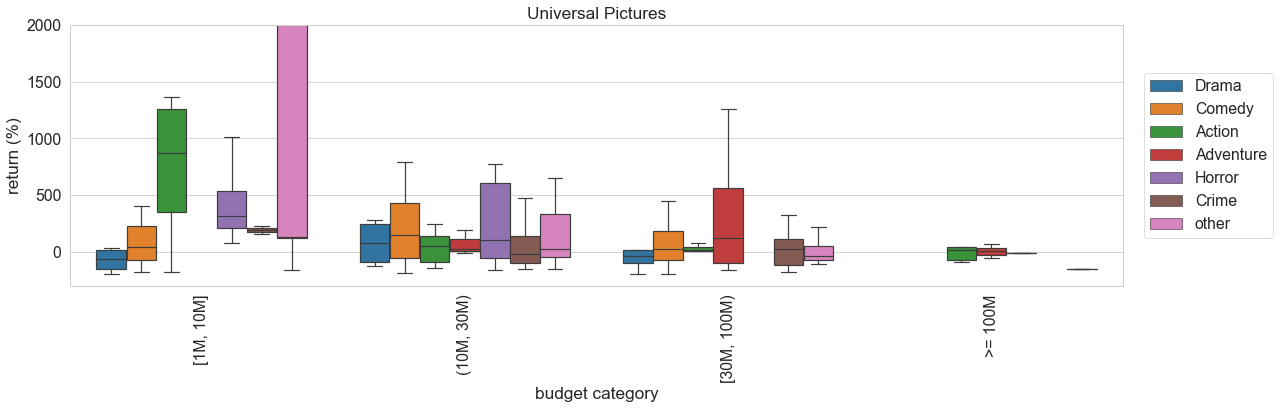

In [816]:
# return vs budget for most common genres
company = 'Universal Pictures' 
filter_UP = (df.first_company == company)
plot_return_filter(filter_add = filter_UP,
                   hue_by = 'select_genre',
                   hue_order = hueorder,
                   _xlim = (2.5,6.5),
                   _ylim = (-300,2000),
                   _title = company)

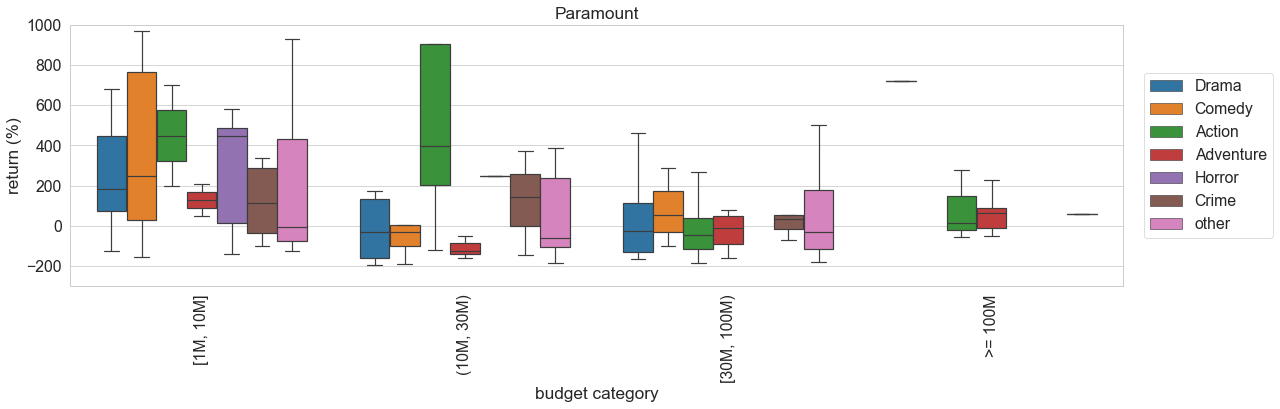

In [817]:
#return vs budget for most common genres
company = 'Paramount' 
filter_UP = (df.first_company == company)
plot_return_filter(filter_add = filter_UP,
                   hue_by = 'select_genre',
                   hue_order = hueorder,
                   _xlim = (2.5,6.5),
                   _ylim = (-300,1000),
                   _title = company)

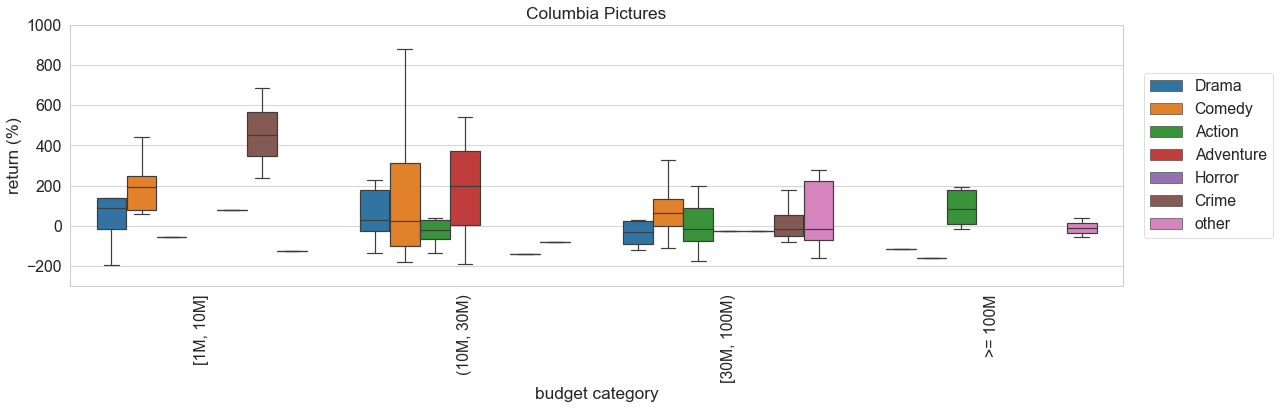

In [818]:
#return vs budget for most common genres
company = 'Columbia Pictures'
filter_UP = (df.first_company == company)
plot_return_filter(filter_add = filter_UP,
                   hue_by = 'select_genre',
                   hue_order = hueorder,
                   _xlim = (2.5,6.5),
                   _ylim = (-300,1000),
                   _title =company)

### Questions to answer: How much money to invest? In what company? In what genre? 
 * For (1M,30M) budget choose Paramount company to film Action movies

Need to optimize return (%) (large median), minimaze risk (low std) for a given budget category.

In [819]:
#Having sufficient data, optimize return (large median) and minimaze risk (low std) 
#First select budget range than company and after that genre
df[filter_cond & filter_other_company].groupby(['budget_category'
                                        ,'select_company'
                                        ,'select_genre'])['gain/loss_%']\
                              .agg(['count','median','std'])\
                              .sort_values(by='std',axis=0,ascending=True)\
                              .sort_values(by=['count','median'],axis=0,ascending=False).head(10)

count  median    std
budget_category select_company     select_genre                      
(10M, 30M)      Universal Pictures Comedy           17  150.58 405.14
[30M, 100M)     Paramount          Action           16  -47.33 123.10
(10M, 30M)      Universal Pictures Drama            15   75.10 406.07
                New Line Cinema    Comedy           15    6.67 378.78
                Paramount          Drama            15  -33.61 595.88
[30M, 100M)     Columbia Pictures  Comedy           14   60.84 176.41
[1M, 10M]       Universal Pictures Comedy           14   44.19 727.37
[30M, 100M)     Universal Pictures Comedy           14   28.46 178.44
(10M, 30M)      Paramount          Comedy           14  -30.05 176.38
[30M, 100M)     Columbia Pictures  Action           13  -18.83 123.65

In [820]:
#What happens if first optimize return (large median) and minimaze risk (low std) 
#First select budget range than company and after that genre
df[filter_cond & filter_other_company].groupby(['budget_category'
                                        ,'first_company'
                                        ,'select_genre'])['gain/loss_%']\
                              .agg(['count','median','std'])\
                              .sort_values(by='std',axis=0,ascending=True)\
                              .sort_values(by=['median'],axis=0,ascending=False).head(10)

count  median  std
budget_category first_company        select_genre                    
(10k, 1M)       RKO Radio Pictures   Horror            1 2785.07  nan
                Dimension Films      Horror            1 2576.26  nan
[1M, 10M]       Miramax              other             1 2474.11  nan
(10k, 1M)       Columbia Pictures    Drama             1 2300.00  nan
                Miramax              Drama             1 2244.41  nan
                                     Comedy            1 2052.96  nan
(10M, 30M)      Summit Entertainment Comedy            1 1940.75  nan
                20th Century Fox     other             1 1408.19  nan
(10k, 1M)       RKO Radio Pictures   Adventure         1 1288.10  nan
[30M, 100M)     Summit Entertainment Adventure         1 1219.65  nan

In [821]:
#What is this most profitable movie?
df.loc[(df.first_company=='RKO Radio Pictures') 
       &(df.select_genre=='Horror'),
      ['title','year','first_genre','first_company','budget_M','gain/loss_%']]

,title,year,first_genre,first_company,budget_M,gain/loss_%
752,Cat People,1942,Horror,RKO Radio Pictures,0.13,2785.07


In [822]:
#some filtering
df.loc[(df.budget_category=='>= 100M')&
       (df.first_company=='Warner Bros. Pictures'),
       ['title','year','first_genre','first_company','budget_M','gain/loss_%']]

,title,year,first_genre,first_company,budget_M,gain/loss_%
65,Harry Potter and the Philosopher's Stone,2001,Adventure,Warner Bros. Pictures,125.00,581.18
69,Harry Potter and the Order of the Phoenix,2007,Adventure,Warner Bros. Pictures,150.00,425.48
127,Harry Potter and the Half-Blood Prince,2009,Adventure,Warner Bros. Pictures,250.00,173.58
134,The Hobbit: An Unexpected Journey,2012,Adventure,Warner Bros. Pictures,250.00,208.44
842,The Hobbit: The Desolation of Smaug,2013,Adventure,Warner Bros. Pictures,250.00,183.36
826,Harry Potter and the Deathly Hallows: Part 1,2010,Adventure,Warner Bros. Pictures,250.00,181.72
827,Harry Potter and the Deathly Hallows: Part 2,2011,Family,Warner Bros. Pictures,125.00,873.60
783,The Hobbit: The Battle of the Five Armies,2014,Action,Warner Bros. Pictures,250.00,182.41
